In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import matplotlib.pyplot as plt
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 14.9 MB/s eta 0:00:00


In [4]:
pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=a8fb14fee371f2234d28a85b9300f71c5844d839664244604d4d4b43094b8182
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [5]:
#Importing the data file and showing the first 5 rows
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Colab data/Customer Churn.csv')
data.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,FN,FP,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,177.8760,69.7640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,41.4315,60.0000,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,1382.8680,203.6520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,216.0180,74.0020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,131.2245,64.5805,0


In [6]:
#Creating Train and test data for the whole program
X=data.iloc[:,:-1]
y=data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #split the data for training and testing

In [7]:
#creating the model and then fitting the data
rf = RandomForestClassifier(n_estimators=100, random_state=42) 
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
lgbm_pred=clf.predict(X_test)

linreg = LinearRegression()
linreg.fit(X_train, y_train) 
linreg_pred = linreg.predict(X_test)


dtree = DecisionTreeClassifier() 
dtree.fit(X_train, y_train) 
dtree_pred = dtree.predict(X_test)


#finding the accuracy metrics for each model
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

clf_mae = mean_absolute_error(y_test, lgbm_pred)
clf_mse = mean_squared_error(y_test, lgbm_pred)
clf_r2 = r2_score(y_test, lgbm_pred)

lr_mae = mean_absolute_error(y_test, linreg_pred)
lr_mse = mean_squared_error(y_test, linreg_pred)
lr_r2 = r2_score(y_test, linreg_pred)

dt_mae = mean_absolute_error(y_test, dtree_pred)
dt_mse = mean_squared_error(y_test, dtree_pred)
dt_r2 = r2_score(y_test, dtree_pred)

#now that we have the metrics, we put them up in a tabular form

data = {
  
  "R2": [lr_r2,dt_r2,clf_r2,rf_r2],
  "MSE": [lr_mse,dt_mse,clf_mse,rf_mse],
  "MAE": [lr_mae,dt_mae,clf_mae,rf_mae]
}


metrics_table=pd.DataFrame(data,index=["LR", "DT","LGBM","RF"])
metrics_table.head()



,R2,MSE,MAE
LR,0.426568,0.081451,0.169598
DT,0.523201,0.067725,0.067725
LGBM,0.657301,0.048677,0.048677
RF,0.605151,0.056085,0.056085


We can clearly notice that the accuracy metric get better as we move on from Open Box models to Black Box Models. (R2 increases, MSE and MAE decreases)

Permutation explainer: 2206it [17:07,  2.13it/s]


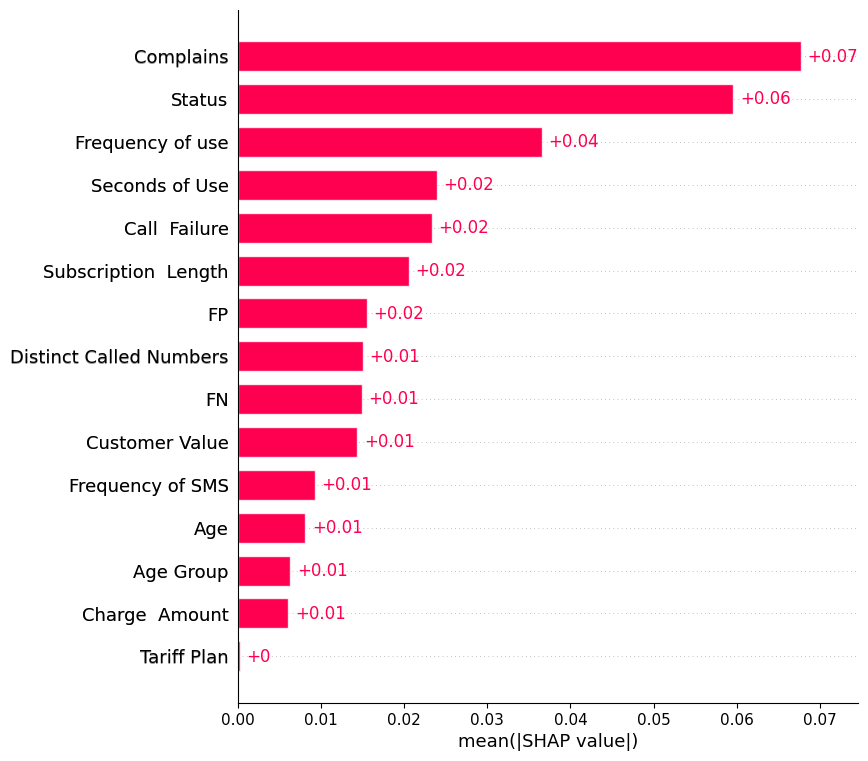

In [8]:
#SHAP
import shap

explainer = shap.Explainer(rf.predict, X_test)
shap_values = explainer(X_train)

shap.plots.bar(shap_values,max_display=20) 
#This bar plot shows the shap values as a bar plot 


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


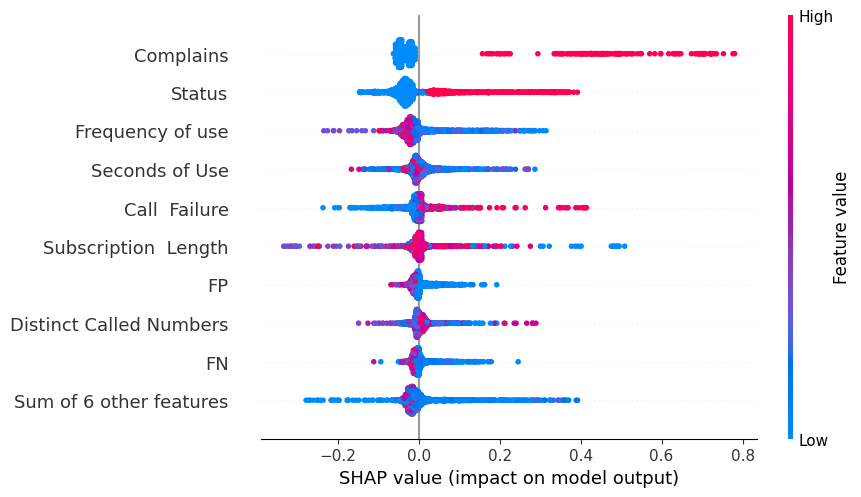

In [9]:
shap.plots.beeswarm(shap_values)

In [10]:
vals= np.abs(shap_values.values).mean(0)

feature_importance = pd.DataFrame(list(zip(X_train.columns,vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)

col_list=feature_importance['col_name'].to_list() #this list contains the names of the features in the decreasing order of shop values


In [11]:
# function defined to return the top n important features
def return_n_imp(n):
  return col_list[0:n]

In [12]:
from lime.lime_tabular import LimeTabularExplainer


from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_normalized_arr=scaler.transform(X_train)
X_train_normalized_df=pd.DataFrame(X_train_normalized_arr, columns=list(X.columns))

X_test_normalized_arr=scaler.transform(X_test)
X_test_normalized_df=pd.DataFrame(X_test_normalized_arr, columns=list(X.columns))


from sklearn.neural_network import MLPClassifier

# create a multi-layer perceptron classifier with one hidden layer
mlp = MLPClassifier(hidden_layer_sizes=(100,), alpha=0.0001)

# fit the model on the training data
mlp.fit(X_train_normalized_df, y_train)

# evaluate the model on the test data
accuracy = mlp.score(X_test_normalized_df, y_test)
print("Test accuracy:", accuracy)

explainer = LimeTabularExplainer(X_train_normalized_df.values, 
                                   feature_names=X_train_normalized_df.columns, 
                                   class_names=['not_churn','churn'], 
                                   verbose=True, 
                                   mode='classification')



Test accuracy: 0.8920634920634921


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


In [13]:
def return_weights(exp):
    
    """Get weights from LIME explanation object"""
    
    exp_list = exp.as_map()[1]
    exp_list = sorted(exp_list, key=lambda x: x[0])
    exp_weight = [x[1] for x in exp_list]
    
    return exp_weight

def imp(model, name,n):

  weights = []

  #Iterate over first 100 rows in feature matrix
  for x in X_test_normalized_df.values[0:100]:
      
      #Get explanation
      exp = explainer.explain_instance(x, 
                                  model.predict_proba, 
                                  num_features=15, 
                                  )
      
      #Get weights
      exp_weight = return_weights(exp)
      weights.append(exp_weight)
      
  #Create DataFrame
  lime_weights = pd.DataFrame(data=weights,columns=X_test_normalized_df.columns)
  print(lime_weights)
    #Get abs mean of LIME weights
  abs_mean = lime_weights.abs().mean(axis=0)
  abs_mean = pd.DataFrame(data={'feature':abs_mean.index, 'abs_mean':abs_mean})
  abs_mean = abs_mean.sort_values('abs_mean')

  #Plot abs mean
  ''' fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8)) '''

  ''' y_ticks = range(len(abs_mean))
  y_labels = abs_mean.feature
  plt.barh(y=y_ticks,width=abs_mean.abs_mean)

  plt.yticks(ticks=y_ticks,labels=y_labels,size= 15)
  plt.title('')
  plt.ylabel('')
  plt.xlabel("Mean |Weight| {}".format(name),size=20) '''

  last_n_index = abs_mean.tail(n).index.astype(str).tolist()
  last_n_index.reverse()
  return last_n_index

In [14]:
mlp_labels_lime = imp(rf,"random_forest",4)#testing

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9955909393186857
Prediction_local [0.91026844]
Right: 0.93
Intercept 0.9947085482429878
Prediction_local [0.91046504]
Right: 0.9
Intercept 0.9861965402456156
Prediction_local [0.93063854]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9927876465033401
Prediction_local [0.91799146]
Right: 0.92
Intercept 0.9917187934582231
Prediction_local [0.92147906]
Right: 0.93
Intercept 0.9965677237980752
Prediction_local [0.90744302]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9943072913880904
Prediction_local [0.91096357]
Right: 0.93
Intercept 0.987987451332911
Prediction_local [0.92438911]
Right: 0.92
Intercept 0.9929484945212433
Prediction_local [0.91600869]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9880582906535929
Prediction_local [0.92903914]
Right: 0.93
Intercept 0.9901323778458876
Prediction_local [0.92377326]
Right: 0.93
Intercept 0.987559260223194
Prediction_local [0.92944309]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9907989762821713
Prediction_local [0.922423]
Right: 0.93
Intercept 0.9927135015698793
Prediction_local [0.91566591]
Right: 0.93
Intercept 0.9885557854438062
Prediction_local [0.93029596]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9909686474350616
Prediction_local [0.92835313]
Right: 0.93
Intercept 0.9197342703712177
Prediction_local [0.99742231]
Right: 0.99
Intercept 0.9886307498599791
Prediction_local [0.92906125]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9892774604784855
Prediction_local [0.92893253]
Right: 0.93
Intercept 0.989379042796533
Prediction_local [0.92962462]
Right: 0.93
Intercept 0.9900607888687941
Prediction_local [0.92488815]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9876236956860992
Prediction_local [0.92882707]
Right: 0.93
Intercept 0.9894977311088669
Prediction_local [0.92715761]
Right: 0.93
Intercept 0.9898756468268396
Prediction_local [0.92482377]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9865039411470132
Prediction_local [0.9302472]
Right: 0.93
Intercept 0.9895096696916238
Prediction_local [0.92673884]
Right: 0.93
Intercept 0.9870666251391053
Prediction_local [0.92908124]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9232357739264145
Prediction_local [0.99167463]
Right: 0.99
Intercept 0.9879438460525991
Prediction_local [0.9295234]
Right: 0.93
Intercept 0.9865082878722398
Prediction_local [0.93007124]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.988089978626371
Prediction_local [0.92860779]
Right: 0.93
Intercept 0.9912094599761756
Prediction_local [0.92018803]
Right: 0.92
Intercept 0.9913238823265335
Prediction_local [0.91728695]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9898745541760664
Prediction_local [0.92675399]
Right: 0.93
Intercept 0.9938992014144536
Prediction_local [0.91521065]
Right: 0.9
Intercept 0.995860427023532
Prediction_local [0.90929242]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9881698440035738
Prediction_local [0.92918729]
Right: 0.93
Intercept 0.9884908677350392
Prediction_local [0.92995358]
Right: 0.93
Intercept 0.9915346294944783
Prediction_local [0.92186715]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9884385521741867
Prediction_local [0.92850004]
Right: 0.93
Intercept 0.9884484408613442
Prediction_local [0.92831143]
Right: 0.93
Intercept 0.9916588506337191
Prediction_local [0.92320786]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9881065657014833
Prediction_local [0.92972314]
Right: 0.93
Intercept 0.9870750640328971
Prediction_local [0.92865359]
Right: 0.93
Intercept 0.9876199354145243
Prediction_local [0.92892536]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9929260249983488
Prediction_local [0.9189244]
Right: 0.92
Intercept 0.9882205709309118
Prediction_local [0.92455418]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9944620399667476
Prediction_local [0.90995625]
Right: 0.9
Intercept 0.9908962374840142
Prediction_local [0.9227157]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9884289104322349
Prediction_local [0.93074939]
Right: 0.93
Intercept 0.9925193568429518
Prediction_local [0.91599444]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9924558590843292
Prediction_local [0.91582608]
Right: 0.93
Intercept 0.9970127218503015
Prediction_local [0.90660963]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9926218627494505
Prediction_local [0.91979007]
Right: 0.92
Intercept 0.9936045975835903
Prediction_local [0.91614491]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9868490195363622
Prediction_local [0.92979527]
Right: 0.93
Intercept 0.9883982208930402
Prediction_local [0.92935641]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9932064135554078
Prediction_local [0.92134879]
Right: 0.93
Intercept 0.9964116246482012
Prediction_local [0.90376227]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9880259509664533
Prediction_local [0.92415807]
Right: 0.93
Intercept 0.9875006974719457
Prediction_local [0.92968106]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9922409509516533
Prediction_local [0.91999466]
Right: 0.89
Intercept 0.9901227397540305
Prediction_local [0.923965]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9881098988751059
Prediction_local [0.92924874]
Right: 0.93
Intercept 0.9888847600450626
Prediction_local [0.92921299]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.921263787834389
Prediction_local [0.9953954]
Right: 0.99
Intercept 0.9876334843155439
Prediction_local [0.93036138]
Right: 0.93
Intercept 0.9880287755821455
Prediction_local [0.93075491]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.986727328682337
Prediction_local [0.92903646]
Right: 0.93
Intercept 0.98890818995719
Prediction_local [0.92782919]
Right: 0.93
Intercept 0.9919187720177624
Prediction_local [0.9155487]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.988941793807625
Prediction_local [0.92353506]
Right: 0.93
Intercept 0.9884630309165835
Prediction_local [0.93034448]
Right: 0.93
Intercept 0.988055203695166
Prediction_local [0.92925708]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9888644042022752
Prediction_local [0.92992469]
Right: 0.93
Intercept 0.9972287184713509
Prediction_local [0.90670003]
Right: 0.93
Intercept 0.9876499431267896
Prediction_local [0.92912624]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.988795294120031
Prediction_local [0.93007371]
Right: 0.93
Intercept 0.9985264732417812
Prediction_local [0.90524088]
Right: 0.93
Intercept 0.9874767179642469
Prediction_local [0.92984398]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9912116667113213
Prediction_local [0.91994143]
Right: 0.93
Intercept 0.9965299052080996
Prediction_local [0.90606172]
Right: 0.93
Intercept 0.9871901792240731
Prediction_local [0.92962316]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9881235402037986
Prediction_local [0.92759299]
Right: 0.93
Intercept 0.9939956237385288
Prediction_local [0.91768177]
Right: 0.89
Intercept 0.9906295731621438
Prediction_local [0.91729632]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9883921817968994
Prediction_local [0.93019154]
Right: 0.93
Intercept 0.993137909703509
Prediction_local [0.91709661]
Right: 0.9
Intercept 0.9875217564089402
Prediction_local [0.92935967]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9877714817413464
Prediction_local [0.92971777]
Right: 0.93
Intercept 0.9923305619547589
Prediction_local [0.91888307]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9917240986561631
Prediction_local [0.91615208]
Right: 0.93
Intercept 0.9887479223708774
Prediction_local [0.92927391]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9882887991407004
Prediction_local [0.9286843]
Right: 0.93
Intercept 0.9885908406892896
Prediction_local [0.92493786]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9875082659080828
Prediction_local [0.9292461]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9880630857736581
Prediction_local [0.92970446]
Right: 0.93
Intercept 0.9218446347039684
Prediction_local [0.99538115]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9929374295821202
Prediction_local [0.91521975]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9880315550496981
Prediction_local [0.92999969]
Right: 0.93
    Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0       -0.000277  -0.067157             -0.000617       -0.004984   
1        0.000048  -0.066947              0.000225        0.002412   
2       -0.000083  -0.066503             -0.000044        0.002407   
3       -0.000171  -0.067321             -0.000237       -0.005145   
4        0.000904  -0.067016              0.000513       -0.005023   
..            ...        ...                   ...             ...   
95      -0.000049  -0.067248             -0.000482        0.002257   
96       0.000342  -0.066745             -0.000163        0.002932   
97      -0.000579   0.066947              0.000278        0.002174   
98       0.000002  -0.067087             -0.000251        0.002625   
99       0.000318  -0.067054              0.000580        0.002349   

    Seconds of Use  Frequency of use  Frequency of SMS  \
0         0.000082          0.

In [15]:
#defining the errors as functions
MSE=mean_squared_error(y_test,rf.predict(X_test))
MAE=mean_absolute_error(y_test,rf.predict(X_test))
R2=r2_score(y_test,rf.predict(X_test))
print(MSE,MAE,R2)#errors with all features
r2n=np.zeros(15)
maen=np.zeros(15)
msen=np.zeros(15)
Dn=np.zeros(15)

0.056084656084656084 0.056084656084656084 0.6051511281396338


In [16]:
for i in range(15):

  X1_train=X_train.drop(return_n_imp(i),axis=1)
  X1_test=X_test.drop(return_n_imp(i),axis=1)
  clf1 = lgb.LGBMClassifier() #create the model
  clf1.fit(X1_train, y_train)
  MSE1=mean_squared_error(y_test,clf1.predict(X1_test))
  MAE1=mean_absolute_error(y_test,clf1.predict(X1_test))
  R21=r2_score(y_test,clf1.predict(X1_test))
  r2n[i]=R21
  maen[i]=MAE1
  msen[i]=MSE1
  #Dn[i]=MSE1+MAE1-R21+R2-MAE-MSE
  #Dn[i]=R2-R21+(MSE1-MSE)

In [17]:
X1_train=X_train.drop(return_n_imp(7),axis=1)
X1_train#testing the dropping of features

,Charge Amount,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Age,Customer Value,FN
3082,2,11,4,5,1,55,26.295,23.6655
1454,0,0,26,1,1,15,107.360,96.6240
1498,0,197,3,3,1,30,945.240,850.7160
2561,0,36,34,3,1,30,272.520,245.2680
549,0,0,3,3,1,30,35.880,32.2920
...,...,...,...,...,...,...,...,...
3092,1,26,15,2,1,25,187.560,168.8040
1095,0,78,40,1,2,15,771.265,694.1385
1130,1,12,22,4,1,45,195.850,176.2650
1294,0,11,8,2,1,25,109.260,98.3340


Text(0.5, 1.0, 'R2 vs features')

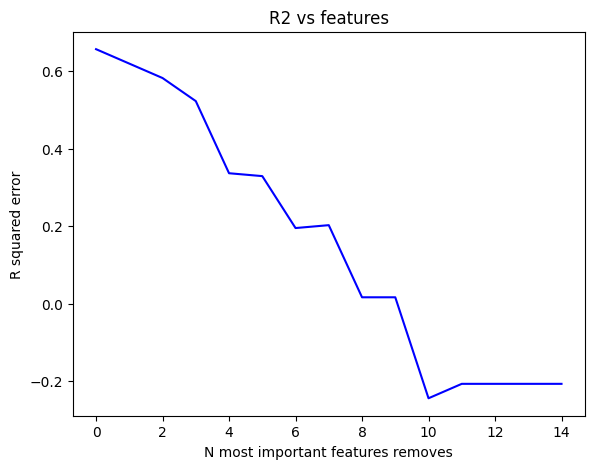

In [18]:
figr2 = plt.figure()


axesr2 = figr2.add_axes([0.1, 0.1, 0.8, 0.8]) 


axesr2.plot(list(range(0,15)), r2n, 'b')
axesr2.set_xlabel('N most important features removes') 
axesr2.set_ylabel('R squared error')
axesr2.set_title('R2 vs features')

Text(0.5, 1.0, 'MAE vs features')

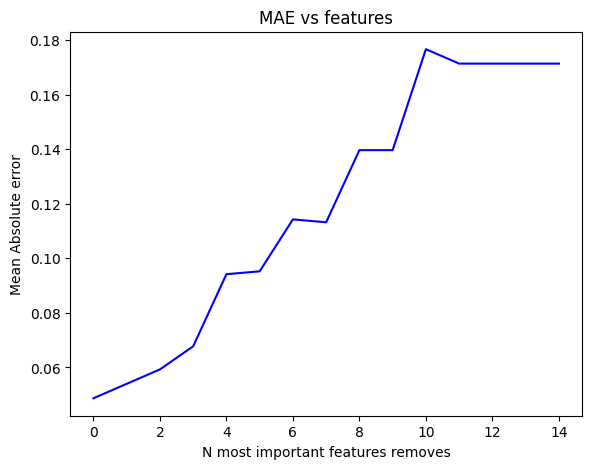

In [19]:
figmea = plt.figure()


axesmea = figmea.add_axes([0.1, 0.1, 0.8, 0.8]) 


axesmea.plot(list(range(0,15)), maen, 'b')
axesmea.set_xlabel('N most important features removes') 
axesmea.set_ylabel('Mean Absolute error')
axesmea.set_title('MAE vs features')

Text(0.5, 1.0, 'MSE vs features')

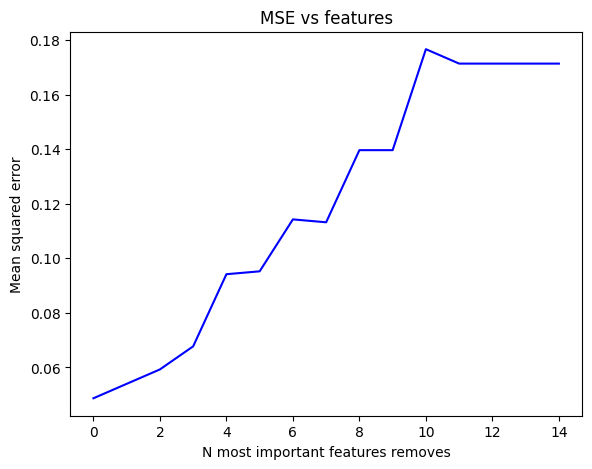

In [20]:
figmse = plt.figure()


axesmse = figmse.add_axes([0.1, 0.1, 0.8, 0.8]) 


axesmse.plot(list(range(0,15)), msen, 'b')
axesmse.set_xlabel('N most important features removes') 
axesmse.set_ylabel('Mean squared error')
axesmse.set_title('MSE vs features')

In [21]:
nmse=msen[14]-msen[0]
nmae=maen[14]-maen[0]
for i in range(15):

  X1_train=X_train.drop(return_n_imp(i),axis=1)
  X1_test=X_test.drop(return_n_imp(i),axis=1)
  clf1 = lgb.LGBMClassifier() #create the model
  clf1.fit(X1_train, y_train)
  MSE1=mean_squared_error(y_test,clf1.predict(X1_test))
  MAE1=mean_absolute_error(y_test,clf1.predict(X1_test))
  R21=r2_score(y_test,clf1.predict(X1_test))
  #Dn[i]=MSE1+MAE1-R21+R2-MAE-MSE
  Dn[i]=R2-R21+(MSE1-MSE)/nmse +(MAE1-MAE)/nmae

Text(0.5, 1.0, 'D vs features')

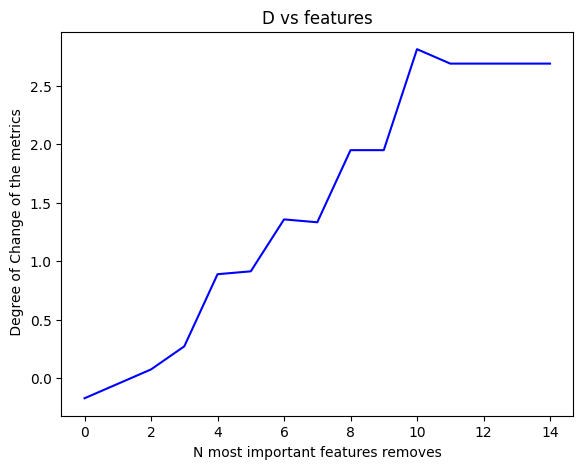

In [22]:
figD = plt.figure()


axesD = figD.add_axes([0.1, 0.1, 0.8, 0.8]) 


axesD.plot(list(range(0,15)), Dn, 'b')
axesD.set_xlabel('N most important features removes') 
axesD.set_ylabel(' Degree of Change of the metrics')
axesD.set_title('D vs features')

In [23]:
x=random.sample(range(15),15)

r2r=np.zeros(15)
maer=np.zeros(15)
mser=np.zeros(15)
D2=np.zeros(15)
print(x)

[0, 3, 7, 13, 4, 11, 5, 14, 1, 9, 10, 2, 12, 8, 6]


In [24]:
for i in range(15):

  X2_train=X_train.drop(X_test.columns[x[0:i]],axis=1)
  X2_test=X_test.drop(X_test.columns[x[0:i]],axis=1)
  clf2 = lgb.LGBMClassifier() #create the model
  clf2.fit(X2_train, y_train)
  MSE2=mean_squared_error(y_test,clf2.predict(X2_test))
  MAE2=mean_absolute_error(y_test,clf2.predict(X2_test))
  R22=r2_score(y_test,clf2.predict(X2_test))
  r2r[i]=R22
  maer[i]=MAE2
  mser[i]=MSE2
  #Dn[i]=MSE1+MAE1-R21+R2-MAE-MSE
  #Dn[i]=R2-R21+(MSE1-MSE)

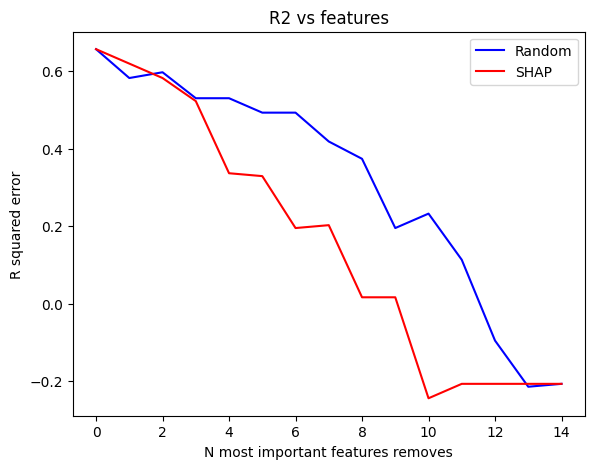

In [25]:
figr2r = plt.figure()


axesr2r = figr2r.add_axes([0.1, 0.1, 0.8, 0.8]) 


axesr2r.plot(list(range(0,15)), r2r, 'b',label='Random')
axesr2r.plot(list(range(0,15)), r2n, 'r',label='SHAP')
axesr2r.set_xlabel('N most important features removes') 
axesr2r.set_ylabel('R squared error')
axesr2r.set_title('R2 vs features')
axesr2r.legend()

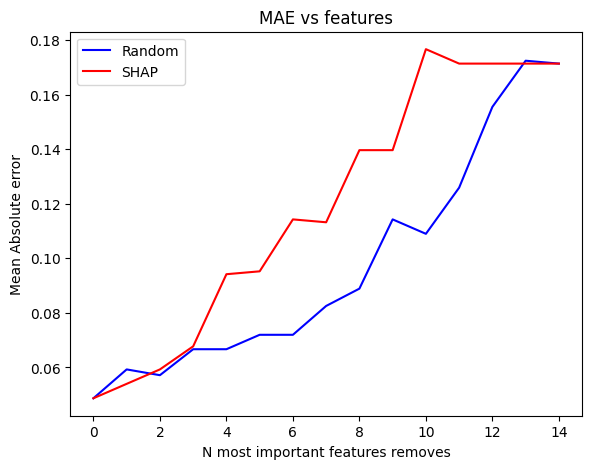

In [26]:
figmear = plt.figure()


axesmear = figmear.add_axes([0.1, 0.1, 0.8, 0.8]) 


axesmear.plot(list(range(0,15)), maer, 'b',label='Random')
axesmear.plot(list(range(0,15)), maen, 'r',label='SHAP')
axesmear.set_xlabel('N most important features removes') 
axesmear.set_ylabel('Mean Absolute error')
axesmear.set_title('MAE vs features')
axesmear.legend()

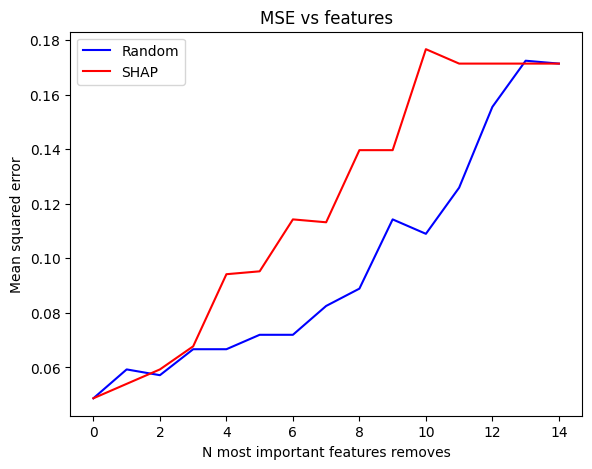

In [27]:
figmser = plt.figure()


axesmser = figmser.add_axes([0.1, 0.1, 0.8, 0.8]) 


axesmser.plot(list(range(0,15)), mser, 'b',label='Random')
axesmser.plot(list(range(0,15)), msen, 'r',label='SHAP')
axesmser.set_xlabel('N most important features removes') 
axesmser.set_ylabel('Mean squared error')
axesmser.set_title('MSE vs features')
axesmser.legend()

In [28]:
rmse=mser[14]-mser[0]
rmae=maer[14]-maer[0]
for i in range(15):

  X2_train=X_train.drop(X_test.columns[x[0:i]],axis=1)
  X2_test=X_test.drop(X_test.columns[x[0:i]],axis=1)
  clf2 = lgb.LGBMClassifier() #create the model
  clf2.fit(X2_train, y_train)
  MSE2=mean_squared_error(y_test,clf2.predict(X2_test))
  MAE2=mean_absolute_error(y_test,clf2.predict(X2_test))
  R22=r2_score(y_test,clf2.predict(X2_test))
  #Dn[i]=MSE1+MAE1-R21+R2-MAE-MSE
  D2[i]=R2-R22+(MSE2-MSE)/rmse +(MAE2-MAE)/rmae

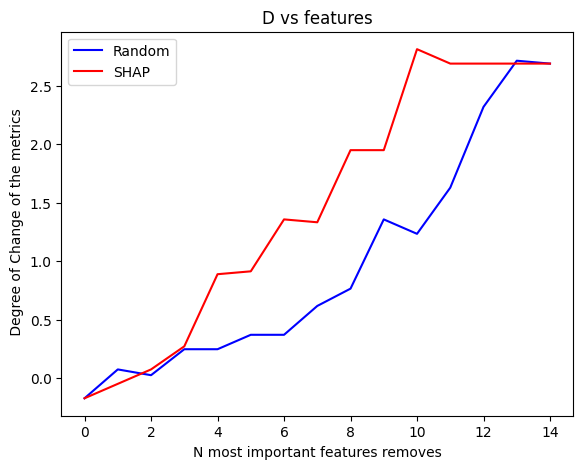

In [45]:
figDr = plt.figure()


axesDr = figDr.add_axes([0.1, 0.1, 0.8, 0.8]) 


axesDr.plot(list(range(0,15)), D2, 'b',label='Random')
axesDr.plot(list(range(0,15)), Dn, 'r',label='SHAP')
axesDr.set_xlabel('N most important features removes') 
axesDr.set_ylabel(' Degree of Change of the metrics')
axesDr.set_title('D vs features')
axesDr.legend()

In [31]:
r2l=np.zeros(15)
mael=np.zeros(15)
msel=np.zeros(15)
Dl=np.zeros(15)


In [36]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

for i in range(15):
  a = imp(clf,"random_forest",i)
  X3_train=X_train.drop(a,axis=1)
  X3_test=X_test.drop(a,axis=1)
  
  clf3 = lgb.LGBMClassifier() #create the model
  clf3.fit(X3_train, y_train)
  
  MSE3=mean_squared_error(y_test,clf3.predict(X3_test))
  MAE3=mean_absolute_error(y_test,clf3.predict(X3_test))
  R23=r2_score(y_test,clf3.predict(X3_test))
  r2l[i]=R23
  mael[i]=MAE3
  msel[i]=MSE3
  #Dn[i]=MSE1+MAE1-R21+R2-MAE-MSE
  #Dn[i]=R2-R21+(MSE1-MSE)

Streaming output truncated to the last 5000 lines.
Prediction_local [0.99487096]
Right: 0.9948577292992997
Intercept 0.9999715392665494
Prediction_local [0.99487619]
Right: 0.9948577292992997
    Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0   -6.564934e-06  -0.004747         -8.467704e-06        0.000246   
1   -2.854177e-06  -0.004767          1.975231e-07       -0.000339   
2   -3.639378e-06  -0.004775         -2.087794e-06       -0.000342   
3    1.885373e-06  -0.004766         -5.106240e-06        0.000249   
4    2.681818e-07  -0.004755         -5.888455e-06        0.000251   
..            ...        ...                   ...             ...   
95  -3.699231e-06  -0.004767         -4.766290e-06       -0.000344   
96  -7.830499e-07  -0.004752          2.122144e-07       -0.000340   
97   1.828593e-06   0.004766         -9.491667e-07       -0.000336   
98  -2.832982e-06  -0.004775         -4.241143e-07       -0.000339   
99   1.060283e-06  -0.004764          

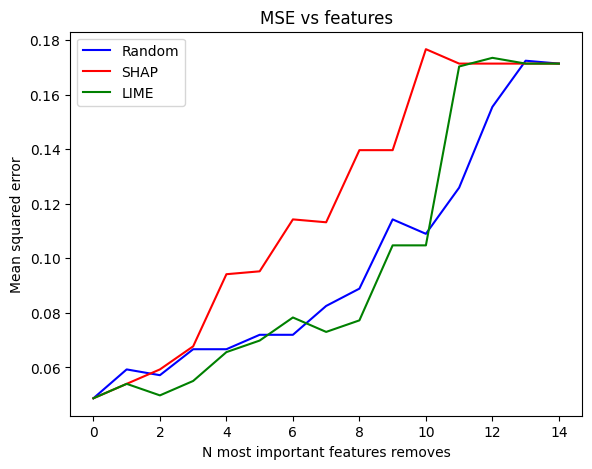

In [37]:
figmser = plt.figure()


axesmser = figmser.add_axes([0.1, 0.1, 0.8, 0.8]) 


axesmser.plot(list(range(0,15)), mser, 'b',label='Random')
axesmser.plot(list(range(0,15)), msen, 'r',label='SHAP')
axesmser.plot(list(range(0,15)), msel, 'g',label='LIME')
axesmser.set_xlabel('N most important features removes') 
axesmser.set_ylabel('Mean squared error')
axesmser.set_title('MSE vs features')
axesmser.legend()

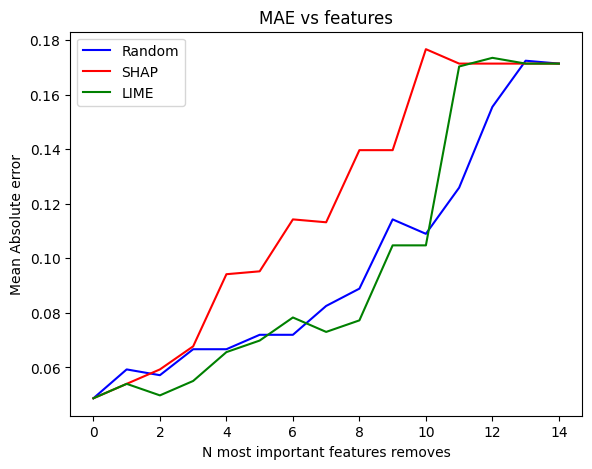

In [38]:
figmear = plt.figure()


axesmear = figmear.add_axes([0.1, 0.1, 0.8, 0.8]) 


axesmear.plot(list(range(0,15)), maer, 'b',label='Random')
axesmear.plot(list(range(0,15)), maen, 'r',label='SHAP')
axesmear.plot(list(range(0,15)), mael, 'g',label='LIME')
axesmear.set_xlabel('N most important features removes') 
axesmear.set_ylabel('Mean Absolute error')
axesmear.set_title('MAE vs features')
axesmear.legend()

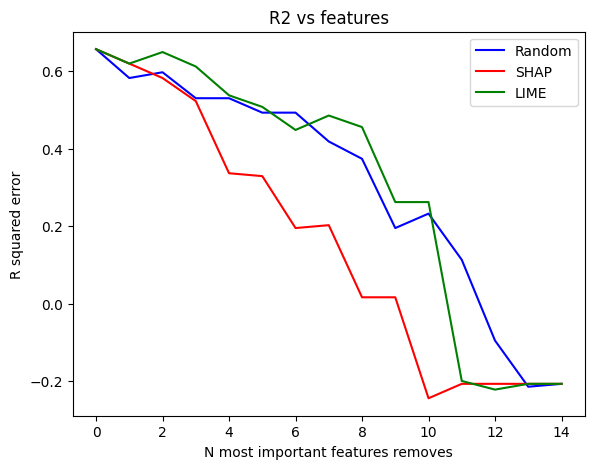

In [39]:
figr2r = plt.figure()


axesr2r = figr2r.add_axes([0.1, 0.1, 0.8, 0.8]) 


axesr2r.plot(list(range(0,15)), r2r, 'b',label='Random')
axesr2r.plot(list(range(0,15)), r2n, 'r',label='SHAP')
axesr2r.plot(list(range(0,15)), r2l, 'g',label='LIME')
axesr2r.set_xlabel('N most important features removes') 
axesr2r.set_ylabel('R squared error')
axesr2r.set_title('R2 vs features')
axesr2r.legend()

In [40]:
D3=np.zeros(15)
lmse=msel[14]-msel[0]
lmae=mael[14]-mael[0]
for i in range(15):

  X3_train=X_train.drop(return_n_imp(i),axis=1)
  X3_test=X_test.drop(return_n_imp(i),axis=1)
  rf3 = RandomForestClassifier(n_estimators=100, random_state=42) #create the model
  rf3.fit(X3_train, y_train)
  MSE3=mean_squared_error(y_test,rf3.predict(X3_test))
  MAE3=mean_absolute_error(y_test,rf3.predict(X3_test))
  R23=r2_score(y_test,rf3.predict(X3_test))
  #Dn[i]=MSE1+MAE1-R21+R2-MAE-MSE
  D3[i]=R2-R23+(MSE3-MSE)/lmse +(MAE3-MAE)/lmae

In [41]:
axesDr = figDr.add_axes([0.1, 0.1, 0.8, 0.8]) 


axesDr.plot(list(range(0,15)), D2, 'b',label='Random')
axesDr.plot(list(range(0,15)), Dn, 'r',label='SHAP')
axesDr.plot(list(range(0,15)), D3, 'g',label='LIME')
axesDr.set_xlabel('N most important features removes') 
axesDr.set_ylabel(' Degree of Change of the metrics')
axesDr.set_title('D vs features')
axesDr.legend()

In [43]:
D2m=np.mean(D2)
Dnm=np.mean(Dn)
D3m=np.mean(D3)
print(D2m)
print(Dnm)
print(D3m)

0.966255144032922
1.4732510288065843
1.576954732510288
